## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("/content/ha_1.csv")

#dummify
data['diagnosis'] = data['diagnosis'].map({'Disease': 0, 'No Disease': 1})

X = data[['age', 'chol']]  # Predictors
y = data['diagnosis']  # Target variable


## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [8]:
# Pipeline
ct = ColumnTransformer(
    [("num", StandardScaler(), ['age', 'chol'])],
    remainder="drop"
)

pipeline_log = Pipeline(
    [("preprocessing", ct),
     ("log", LogisticRegression())]
)

# Fit the pipeline
pipeline_log.fit(X, y)

# Access the Logistic Regression model from the pipeline
model = pipeline_log.named_steps["log"]

# Get intercept and coefficients
beta_0 = model.intercept_[0]
beta_1, beta_2 = model.coef_[0]

age = 55

# Cholesterol threshold for P = 0.5
chol_threshold_50 = -(beta_0 + beta_1 * age) / beta_2
print(f"Cholesterol threshold for P=0.5 (predicting heart disease): {chol_threshold_50}")

# Cholesterol threshold for P = 0.9
P = 0.9
log_odds_90 = np.log(P / (1 - P))
chol_threshold_90 = (log_odds_90 - beta_0 - beta_1 * age) / beta_2
print(f"Cholesterol threshold for P=0.9 (90% chance of heart disease): {chol_threshold_90}")

Cholesterol threshold for P=0.5 (predicting heart disease): -242.14639682791758
Cholesterol threshold for P=0.9 (90% chance of heart disease): -219.2527805661068


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [4]:

#pipeline
ct = ColumnTransformer(
    [("num", StandardScaler(), ['age', 'chol'])],
    remainder="drop"
)

pipeline_lda = Pipeline(
    [("preprocessing", ct),
     ("lda", LinearDiscriminantAnalysis())]
)

# Fit pipeline
pipeline_lda.fit(X, y)

# Get scaled coefficients and intercept
lda_model = pipeline_lda.named_steps['lda']
scaled_coefficients = lda_model.coef_[0]
scaled_intercept = lda_model.intercept_[0]

# Reverse scaling
scaler = pipeline_lda.named_steps['preprocessing'].named_transformers_['num']
mean = scaler.mean_
scale = scaler.scale_

# Adjust coefficients and intercept to original space
coefficients_original = scaled_coefficients / scale
intercept_original = scaled_intercept - np.dot(coefficients_original, mean / scale)

print(f"Original Coefficients: {coefficients_original}")
print(f"Original Intercept: {intercept_original}")

# Calculate cholesterol threshold for age 55
age = 55
chol_threshold = -(intercept_original + coefficients_original[0] * age) / coefficients_original[1]
print(f"Cholesterol threshold for age {age}: {chol_threshold}")


Original Coefficients: [0.04655744 0.00178967]
Original Intercept: -0.5465976247684387
Cholesterol threshold for age 55: -1125.3832209027894


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [5]:
# Preprocessing: Scale 'age' and 'chol'
ct = ColumnTransformer(
    [("num", StandardScaler(), [0, 1])], # Use column indices instead of names
    remainder="drop"
)

# Define the SVC model pipeline
pipeline_svc = Pipeline([
    ("preprocessing", ct),
    ("svc", SVC(kernel="linear", probability=True))  # Use a linear kernel for interpretability
])

# Grid search for the regularization parameter C
param_grid = {'svc__C': np.logspace(-3, 3, 7)}  # Test C values from 0.001 to 1000
grid_search = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X, y)

# Best model from the grid search
best_svc = grid_search.best_estimator_


In [6]:
# Predict the threshold cholesterol for a 55-year-old
# Incrementally increase cholesterol until the model predicts heart disease (y = 1)
age = 55
chol = 100  # Start with a baseline cholesterol value
threshold_chol = None

while chol < 400:  # Search up to a reasonable cholesterol value
    test_data = np.array([[age, chol]])
    prediction = best_svc.predict(test_data)
    if prediction == 1:  # Heart disease predicted
        threshold_chol = chol
        break
    chol += 1

if threshold_chol:
    print(f"A 55-year-old would need a cholesterol level of at least {threshold_chol} for heart disease to be predicted.")
else:
    print("Heart disease was not predicted for any cholesterol level in the tested range.")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but 

A 55-year-old would need a cholesterol level of at least 313 for heart disease to be predicted.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but 

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

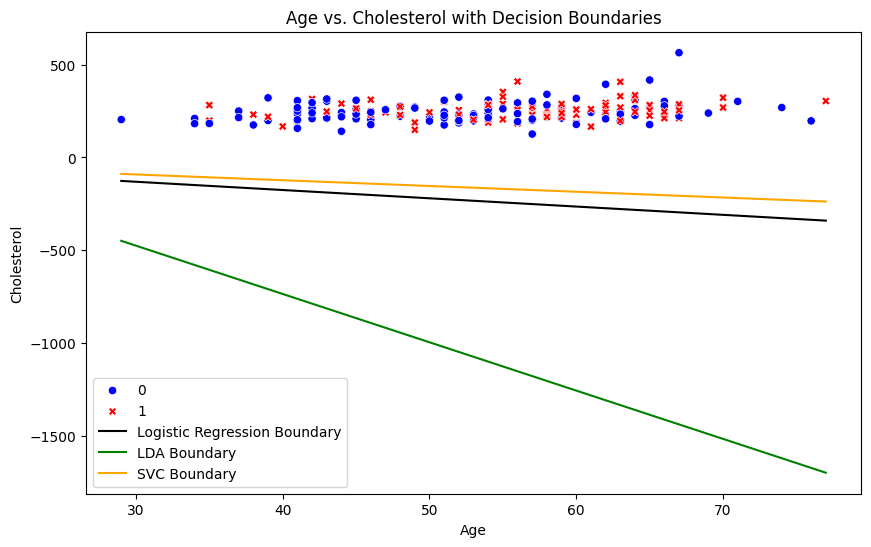

In [17]:

# Scatterplot of data points
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='age', y='chol', hue='diagnosis',
                palette={0: 'blue', 1: 'red'}, style='diagnosis')

age_vals = np.linspace(data['age'].min(), data['age'].max(), 100)

# 1. Logistic Regression Boundary
model_log = pipeline_log.named_steps["log"]  # Extract logistic regression model
beta_0_log = model_log.intercept_[0]
beta_1_log, beta_2_log = model_log.coef_[0]  # Coefficients for 'age' and 'chol'

# Calculate decision boundary
chol_vals_logreg = -(beta_0_log + beta_1_log * age_vals) / beta_2_log
plt.plot(age_vals, chol_vals_logreg, label='Logistic Regression Boundary', color='black')

# 2. LDA Boundary
model_lda = pipeline_lda.named_steps["lda"]  # Extract LDA model
scaled_coeff_lda = model_lda.coef_[0]
scaled_intercept_lda = model_lda.intercept_[0]

# Reverse scaling for coefficients and intercept
scaler = pipeline_lda.named_steps['preprocessing'].named_transformers_['num']
mean = scaler.mean_
scale = scaler.scale_
coeff_lda = scaled_coeff_lda / scale
intercept_lda = scaled_intercept_lda - np.dot(coeff_lda, mean / scale)

# Calculate decision boundary
chol_vals_lda = -(intercept_lda + coeff_lda[0] * age_vals) / coeff_lda[1]
plt.plot(age_vals, chol_vals_lda, label='LDA Boundary', color='green')

# 3. SVC Boundary
svc_model = best_svc.named_steps["svc"]  # Extract SVC model
coef_svc = svc_model.coef_[0]  # Coefficients for 'age' and 'chol'
intercept_svc = svc_model.intercept_[0]

# Calculate decision boundary
chol_vals_svc = -(intercept_svc + coef_svc[0] * age_vals) / coef_svc[1]
plt.plot(age_vals, chol_vals_svc, label='SVC Boundary', color='orange')

# Plot aesthetics
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.title('Age vs. Cholesterol with Decision Boundaries')
plt.legend()
plt.show()
